In [1]:
#encoding="utf-8"
import pandas as pd
import numpy as np
import time
import requests
import json
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)
#df.dropna(inplace=True)

In [69]:
# 获取k线数据（现货）
def get_klinedata(platform, symbol, granularity):
    df=pd.DataFrame()
    # [时间，开盘价，收盘价，交易量]
    if platform == "huobi":  # 200条数据，时间粒度1min, 5min, 15min, 30min, 60min, 4hour, 1day, 1mon, 1week, 1year
        huobi_granularity_dict = {60: "1min", 300: "5min", 900: "15min", 1800: "30min", 3600: "60min",
                                      14400: "4hour", 86400: "1day", 604800: "1week", 2592000: "mon",
                                      946080000: "1year"}
        for _ in range(3):
            try:
                response = requests.get("https://api.huobi.pro/market/history/kline?period={}&size=300&symbol={}".format(
                           huobi_granularity_dict[granularity], symbol.replace("_", "")), timeout=3)
                if response.status_code==200:
                    res=response.json()['data'][::-1]
                    df['close'] = [i['close'] for i in res]
                    df['time']=[time.strftime("%Y-%m-%d", time.localtime(i["id"])) for i in res]
                    break
            except Exception as e:
                print(e)
    if platform == "binance": 
        for _ in range(3):
            try:
                #200条数据，时间粒度1m, 5m, 15m, 30m, 1h, 4h, 1d
                binance_granularity_dict = {60: "1m", 300: "5m", 900: "15m", 1800: "30m", 3600: "1h",
                                            14400: "4h", 86400: "1d"}
                response = requests.get("https://www.binancezh.cc/api/v3/klines?symbol={}&interval={}&limit=300".format(
                    symbol.upper().replace("_", ""), binance_granularity_dict[granularity]), timeout=1)
                if response.status_code==200:
                    data = response.json()
                    df['close'] = [float(i[4]) for i in data]
                    break
            except Exception as e:
                print(e)
    return df

In [70]:
#获取多个币种的200日收盘价
def get_symbols_klinedata(platform,symbols,granularity):
    klinedata=None
    for symbol in symbols:
        df=get_klinedata(platform,"{}_usdt".format(symbol),granularity)
        df.rename(columns={'close':symbol},inplace=True) 
        #klinedata=df if klinedata is None else pd.concat([klinedata,df],axis=1)
        klinedata=df if klinedata is None else pd.merge(klinedata,df,how='left',on='time')
    return klinedata

In [71]:
#复合动量因子
def compound_momentum(symbols,df):
    judge_list=None
    for symbol in symbols:
        df['return']=np.log(df[symbol]/df[symbol].shift())
        up_days=np.sum(df['return'].values>0)
        down_days=np.sum(df['return'].values<0)
        return_all=df['return'].sum()
        judge=pd.DataFrame({symbol:[up_days/(up_days+down_days)*return_all]})
        #judge=pd.DataFrame({symbol:[1*return_all]})
        judge_list =judge.T if judge_list is None else pd.concat([judge_list,judge.T],axis=0)
    judge_list.columns=['return']
    judge_list.sort_values(by=['return'], ascending=False, inplace=True)
    return judge_list

In [72]:
#收益率偏度因子
def skew_factor(symbols,df):
    skew_list=None
    for symbol in symbols:
        #df=get_future_klinedata0("T8ex",symbol)
        ret=np.log(df[symbol]/df[symbol].shift())
        ret.columns=[symbol]
        ret_skew=pd.DataFrame({symbol:[ret.skew()]}) #计算偏度后转置，index为【future】,即期货种类代码
        skew_list=ret_skew.T if skew_list is None else pd.concat([skew_list,ret_skew.T],axis=0)
    skew_list.columns=['skew']
    skew_list.sort_values(by=['skew'],ascending=False,inplace=True)
    return skew_list

In [167]:
#收益率峰度因子
def kurt_factor(symbols,df):
    kurt_list=None
    for symbol in symbols:
        ret=np.log(df[symbol]/df[symbol].shift())
        ret.columns=[symbol]
        ret_kurt=pd.DataFrame({symbol:[ret.kurt()]})
        kurt_list=ret_kurt.T if kurt_list is None else pd.concat([kurt_list,ret_kurt.T],axis=0)
    kurt_list.columns=['kurt']
    kurt_list.sort_values(by=['kurt'],ascending=False,inplace=True)
    return kurt_list

In [168]:
def weighted_factor_score(factor, factor_name, weight):
    #给定每只期货合约的因子数据及权重，返回加权后的打分结果
    # weight是因子的权重，是该因子多空组合夏普比率，计算过程省了
    factor.columns = [factor_name]
    factor.iloc[:2]=1
    factor.iloc[2:-2]=0
    factor.iloc[-2:]=0
    factor = factor*weight 
    return factor

In [169]:
#T8ex_kline_url="http://47.241.181.195:1060/contract-market/history"
#huobifuture_api_url='https://api.btcgateway.pro'
symbols = ['btc','eth','link','eos','fil','ltc','dot','doge']
#symbols=['btc','eth','dot','link','ada','doge','xrp','bch','uni','ltc','etc','xlm','omg','sol','trx','fil','eos','bsv','shib','xtz','matic']
#symbols=['btc','eth','link','eos','fil','ltc','dot','uni']
#df=get_contracts_klinedata("binance",symbols)
df= get_symbols_klinedata("huobi",symbols,86400)

In [170]:
df

,btc,time,eth,link,eos,fil,ltc,dot,doge
0,12942.24,2020-10-25,406.06,12.1114,2.6308,32.2102,59.30,4.2868,0.002646
1,12979.23,2020-10-26,393.61,11.6451,2.6398,35.2647,56.23,4.5747,0.002750
2,13606.50,2020-10-27,405.91,12.1955,2.6693,34.3512,58.20,4.7378,0.002676
3,13220.25,2020-10-28,387.57,11.5139,2.6578,34.6978,56.34,4.3567,0.002586
4,13435.23,2020-10-29,390.69,11.5925,2.6541,32.7030,55.49,4.1338,0.002570
5,13551.00,2020-10-30,382.09,11.0982,2.5087,30.2842,53.86,4.0925,0.002575
6,13854.39,2020-10-31,390.14,11.2903,2.5412,31.4003,56.15,4.2487,0.002579
7,13797.96,2020-11-01,388.32,11.1809,2.5121,30.9355,54.95,4.1831,0.002571
8,13492.15,2020-11-02,384.94,10.9314,2.4376,29.8500,53.89,4.0745,0.002523
9,13708.92,2020-11-03,381.44,10.3325,2.3328,28.3698,52.81,3.9503,0.002492


In [171]:
#df=df[['btc','eth','dot','link','ada','doge','xrp','bch','uni','ltc','etc','xlm','omg','sol','trx','fil','eos','bsv','shib','xtz','matic']]
df=df[['btc','eth','link','eos','fil','ltc','dot','doge']]
#df.dropna(inplace=True)

In [172]:
result_list=None
for i in range(250):
    judge_list = weighted_factor_score(compound_momentum(symbols,df.iloc[i+1:50+i+1]), '复合动量',1) #周调仓
    skew_list = weighted_factor_score(skew_factor(symbols,df.iloc[i+1:50+i+1]), '偏度',1)  #周调仓
    kurt_list =weighted_factor_score(kurt_factor(symbols,df.iloc[i+1:50+i+1]),'峰度',1)
    #ware_house = weighted_factor_score(ware_house_factor(symbols,positions.iloc[i+1:i+10+1]), '仓单因子', 1.5)
    #factor_pure_long = weighted_factor_score(pure_long_factor(symbols,pure_long_position.iloc[i+1:i+20+1]), '净多头变化率', 1)
    #result = pd.concat([factor_momentum, judge_list, skew_list], axis=1)
    result=pd.concat([judge_list,skew_list,kurt_list],axis=1)
    result = result.sum(axis=1).sort_values(ascending=False)
    result.iloc[:2] = 1
    result.iloc[2:-2] = 0
    result.iloc[-2:] = 0
    result_list = result if result_list is None else pd.concat([result_list,result], axis=1)

<ipython-input-71-eea9601f5860>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return']=np.log(df[symbol]/df[symbol].shift())


In [173]:
result=result_list.T.reset_index(drop=True)
# df['btc_pct']=np.log(df['btc']/df['btc'].shift())
# df['eth_pct']=np.log(df['eth']/df['eth'].shift())
# df['link_pct']=np.log(df['link']/df['link'].shift())
# df['eos_pct']=np.log(df['eos']/df['eos'].shift())
# df['fil_pct']=np.log(df['fil']/df['fil'].shift())
# df['ltc_pct']=np.log(df['ltc']/df['ltc'].shift())
# #df['uni_pct']=df['uni']/df['uni'].shift()
# df['dot_pct']=np.log(df['dot']/df['dot'].shift())
# df['doge_pct']=np.log(df['doge']/df['doge'].shift())
df['btc_pct']=df['btc'].pct_change()
df['eth_pct']=df['eth'].pct_change()
df['link_pct']=df['link'].pct_change()
df['eos_pct']=df['eos'].pct_change()
df['fil_pct']=df['fil'].pct_change()
df['ltc_pct']=df['ltc'].pct_change()
#df['uni_pct']=df['uni'].pct_change()
df['dot_pct']=df['dot'].pct_change()
df['doge_pct']=df['doge'].pct_change()

In [174]:
df['btc_ma5']=df['btc'].rolling(5).mean()
df['btc_ma10']=df['btc'].rolling(10).mean()

In [175]:
df['ma_stop']=np.where(df['btc_ma5']>df['btc_ma10'],1,0)

In [176]:
df_2=df[['btc_pct','eth_pct','link_pct','eos_pct','fil_pct','ltc_pct','dot_pct','doge_pct','ma_stop']]

In [177]:
df_3=df_2.iloc[50:].reset_index(drop=True)

In [178]:
df_1=pd.concat([df_3,result],axis=1)

In [179]:
df_1['btc_return']=df_1['btc_pct']*df_1['btc'].shift()#*df_1['ma_stop'].shift()
df_1['eth_return']=df_1['eth_pct']*df_1['eth'].shift()#*df_1['ma_stop'].shift()
df_1['link_return']=df_1['link_pct']*df_1['link'].shift()#*df_1['ma_stop'].shift()
df_1['eos_return']=df_1['eos_pct']*df_1['eos'].shift()#*df_1['ma_stop'].shift()
df_1['fil_return']=df_1['fil_pct']*df_1['fil'].shift()#*df_1['ma_stop'].shift()
df_1['ltc_return']=df_1['ltc_pct']*df_1['ltc'].shift()#*df_1['ma_stop'].shift()
#df_1['uni_return']=df_1['uni_pct']*df_1['uni'].shift()
df_1['dot_return']=df_1['dot_pct']*df_1['dot'].shift()#*df_1['ma_stop'].shift()
df_1['doge_return']=df_1['doge_pct']*df_1['doge'].shift()#*df_1['ma_stop'].shift()

In [180]:
df_4=df_1[['btc_return','eth_return','link_return','eos_return','fil_return','ltc_return','dot_return','doge_return',]]
df_4['return']=df_4.sum(axis=1)

<ipython-input-180-40dc90a6c329>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['return']=df_4.sum(axis=1)


In [185]:
result

,fil,eos,doge,ltc,eth,btc,dot,link
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [181]:
df_4

,btc_return,eth_return,link_return,eos_return,fil_return,ltc_return,dot_return,doge_return,return
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.000000,0.000000,0.000000,0.017395,-0.012294,-0.000000,0.000000,0.000000,0.005101
2,0.000000,0.000000,0.000000,0.046690,-0.008452,0.000000,0.000000,0.000000,0.038237
3,0.000000,0.000000,0.000000,0.060082,-0.010115,0.000000,0.000000,0.000000,0.049967
4,-0.000000,-0.000000,-0.000000,-0.000000,-0.017109,-0.011381,-0.000000,-0.000000,-0.028490
5,0.000000,0.000000,0.000000,0.000000,-0.003425,0.118638,0.000000,0.000000,0.115213
6,0.000000,-0.000000,-0.000000,0.000000,-0.004398,0.012247,-0.000000,0.000000,0.007849
7,-0.000000,-0.000000,-0.000000,-0.000000,-0.065023,-0.097967,-0.000000,0.000000,-0.162990
8,0.000000,0.000000,0.000000,-0.000000,-0.046855,0.037537,0.000000,-0.000000,-0.009318
9,0.000000,-0.000000,-0.070815,-0.000000,-0.060778,-0.000000,-0.000000,-0.000000,-0.131592


<AxesSubplot:>

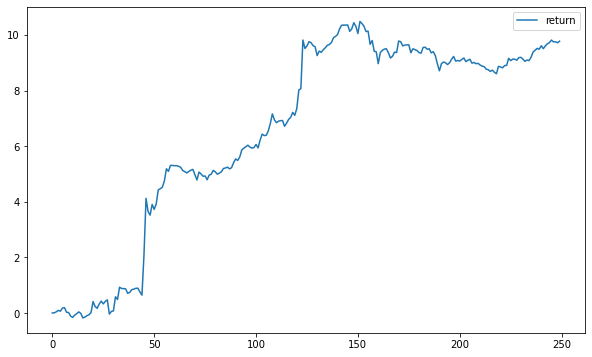

In [182]:
df_4[['return']].cumsum().plot(figsize=(10,6))

In [ ]:
df_4['return']=df_4['return'].apply(lambda x:x-2 if x!=0 else x)

In [ ]:
df_4['btc_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['eth_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['link_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['eos_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['fil_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['ltc_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['dot_return'].cumsum().apply(np.exp).plot(figsize=(10,6))
df_4['doge_return'].cumsum().apply(np.exp).plot(figsize=(10,6))

In [ ]:
df_4['final_btc_return']=df_4['btc_return'].cumsum().apply(np.exp)
df_4['final_eth_return']=df_4['eth_return'].cumsum().apply(np.exp)
df_4['final_link_return']=df_4['link_return'].cumsum().apply(np.exp)
df_4['final_eos_return']=df_4['eos_return'].cumsum().apply(np.exp)
df_4['final_fil_return']=df_4['fil_return'].cumsum().apply(np.exp)
df_4['final_ltc_return']=df_4['ltc_return'].cumsum().apply(np.exp)
df_4['final_dot_return']=df_4['dot_return'].cumsum().apply(np.exp)
df_4['final_doge_return']=df_4['doge_return'].cumsum().apply(np.exp)

In [ ]:
#偏度的含义
#左偏的含义：众数>中位数>平均数，数据位于均值左边的比位于右边的少，直观表现为左边的尾部相对于右边的尾部要长
#右偏的含义：算术平均数>中位数>众数，数据位于均值右边的比位于左边的少，直观表现为右边的尾部相对于左边的尾部要长
#我对偏度的直观理解
#右偏，分布在左边的多，但都是一些小数据（相对均值而言差距较小），分布在右边的少，但数据较大（相对均值而言差距较大）
#左偏，分布在右边的多，但都是一些小数据（相对均值而言差距较小），分布在左边的少，但数据较大（相对均值而言差距较大）
#做多偏度大的，做空偏度小的，就是暴涨做多，暴跌做空，感觉是个动量策略